<a href="https://www.kaggle.com/code/aisuko/character-lm-with-pytorch?scriptVersionId=188052333" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

Let's create neural network with PyTorch with following steps:
* Pre-process dataset
  * Create vocabulary
* Feeding into neural network
  * Convert integer to tensor
* Define Neural network
* Evaluate loss function

In [1]:
words=open('/kaggle/input/character-lm-without-framework/names.txt','r').read().splitlines()
print(len(words))

32033


In [2]:
chars=sorted(list(set(''.join(words))))
stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}

In [3]:
import torch

# create the training set of bigrams (x,y)
xs, ys = [], []

for w in words[:1]:
    chs= ['.'] +list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1=stoi[ch1]
        ix2=stoi[ch2]
        print(ch1,ch2)
        xs.append(ix1)

        ys.append(ix2)
xs=torch.tensor(xs)
ys=torch.tensor(ys)
print(xs)
print(ys)

. e
e m
m m
m a
a .
tensor([ 0,  5, 13, 13,  1])
tensor([ 5, 13, 13,  1,  0])


# Feeding data into neural network

**Note:** We want to feed data with float type into Neural Network, the float number can save deep tie than integer.

We need to use one-hot convert integer to tensor(with fixed length) and feed it into Neural network.

## One-hot encodings(for integers)

```bash
# num_classes-> how long you want the tensor to be?
torch.nn.functionl.one_hot(13, num_classes=27)
```

In [4]:
import torch.nn.functional as F

xenc=F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
xenc.shape

torch.Size([5, 27])

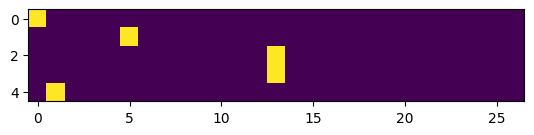

In [5]:
import matplotlib.pyplot as plt

plt.imshow(xenc)

# Define neurons(Single Layer Network)

In [6]:
# randomly initialize 27 neurons' weights. earch neuron receives 27 inputs
g=torch.Generator().manual_seed(2147483647)
# randn returns normalize ditribution
W=torch.randn((27,27), generator=g) # keep same generate data

In [7]:
# evaluate all the 27 neurons in 5 input parallel(with dot-product) and return it
xenc @ W # (5,27) @ (27,27) -> (5,27)
# for everyone of 27 neurons, what is the firing rate of thse neurons(27) on everyone of these 5 examples.

tensor([[ 1.5674e+00, -2.3729e-01, -2.7385e-02, -1.1008e+00,  2.8588e-01,
         -2.9643e-02, -1.5471e+00,  6.0489e-01,  7.9136e-02,  9.0462e-01,
         -4.7125e-01,  7.8682e-01, -3.2843e-01, -4.3297e-01,  1.3729e+00,
          2.9334e+00,  1.5618e+00, -1.6261e+00,  6.7716e-01, -8.4039e-01,
          9.8488e-01, -1.4837e-01, -1.4795e+00,  4.4830e-01, -7.0730e-02,
          2.4968e+00,  2.4448e+00],
        [ 4.7236e-01,  1.4830e+00,  3.1748e-01,  1.0588e+00,  2.3982e+00,
          4.6827e-01, -6.5650e-01,  6.1662e-01, -6.2197e-01,  5.1007e-01,
          1.3563e+00,  2.3445e-01, -4.5585e-01, -1.3132e-03, -5.1161e-01,
          5.5570e-01,  4.7458e-01, -1.3867e+00,  1.6229e+00,  1.7197e-01,
          9.8846e-01,  5.0657e-01,  1.0198e+00, -1.9062e+00, -4.2753e-01,
         -2.1259e+00,  9.6041e-01],
        [ 1.9359e-01,  1.0532e+00,  6.3393e-01,  2.5786e-01,  9.6408e-01,
         -2.4855e-01,  2.4756e-02, -3.0404e-02,  1.5622e+00, -4.4852e-01,
         -1.2345e+00,  1.1220e+00, -6.73

## We use operation fro pytorch do computing in parallel

In [8]:
# we get element from tensor
# it's giving us the firing rate of 13th neuron looking at 3th input
# the way this achieved is by dot product between the third input and 
# the 13th column of or W matrix
(xenc @W)[3,13]

tensor(0.0379)

In [9]:
xenc[3]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [10]:
W[:,13]

tensor([-4.3297e-01, -9.6478e-01,  2.1346e+00, -7.2759e-01, -1.3753e-01,
        -1.3132e-03, -3.1566e-01,  1.1199e+00, -4.7701e-01, -1.5065e+00,
         1.2108e+00, -4.0636e-01,  1.9110e-01,  3.7882e-02,  1.3431e+00,
         2.4311e-01, -1.5364e-01, -1.1583e+00,  1.1614e+00,  4.2016e-01,
         2.7359e-01,  3.6583e-01,  1.7128e+00,  1.3769e+00, -8.9778e-01,
        -9.5177e-01,  1.4723e-01])

In [11]:
# the latest section equal to below, we use the representation above 
# makes the computing process more efficient
(xenc[3]*W[:,13]).sum()

tensor(0.0379)

# Transforming Neural net output into probabilities(The Softmax)

In our scenario, we use `exp()` eponentiated converting all the outputs(counts of number in list N)
* negative number turned into below 1
* positive number tunrned into even more positive numbers(greater than one)


## Softmax activation func

* input(positive and negative)
* $Z_i$ are logits
* exp() them
* divides and normalizes 
* output(positive numbers like probabilities)


$$\frac{e^{Z_i}}{\sum_{j=1}^{K}e^{Z_j}}$$

In [12]:
logits=(xenc@W) # predict logits-counts

# These two lines below are together called a `softmax`
counts=logits.exp() # equivalent N matrix
# probabilities for next character
probs=counts/counts.sum(1, keepdims=True) # normalize the rows
print(probs)
print(probs[0].sum())

tensor([[0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
         0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
         0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459],
        [0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
         0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
         0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472],
        [0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
         0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
         0.0650, 0.0058, 0.0208, 0.0078, 0.0133, 0.0203, 0.1204, 0.0469, 0.0126],
        [0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
         0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
         0.0650, 0.0058, 0.0208, 0.0078, 0.0133, 0.0203, 0.1204, 0.0469, 0.0126],
        [0.0150, 0.0086,

# Evaluate loss function

In [13]:
nlls=torch.zeros(5)

for i in range(5):
    # i-th bigram:
    x=xs[i].item() # input character index
    y=ys[i].item() # label character index
    print('-------')
    print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
    print('input to the neural net:',x)
    print('output probabilities from the neural net:', probs[i])
    print('label (actual next character):',y)
    p=probs[i,y]
    print('probability assigned by the net to the correct character:', p.item())
    logp=torch.log(p)
    print('log likelihood:',logp.item())
    nll=-logp
    print('negative log likelihood:', nll.item())
    nlls[i]=nll
    
print('======')
print('averae negative log likelihood, i.e. loss =', nlls.mean().item())

-------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next character): 5
probability assigned by the net to the correct character: 0.01228625513613224
log likelihood: -4.399273872375488
negative log likelihood: 4.399273872375488
-------
bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label (actual next character): 13
probability assigned by the net to the correct character: 0.0180507004

# Tuning W to minimize the loss with gradient based optimization


# Acknowledge

* https://www.youtube.com/watch?v=PaCmpygFfXo&t=4649s